In [1]:
from copy import deepcopy
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [26]:
from types import SimpleNamespace
from functools import partial

import wandb
import torch, numpy as np
from minai.core import *
from fastprogress import progress_bar
from datasets import load_dataset
from torch import optim
from torch.utils.data import DataLoader
from torcheval.metrics import MulticlassAccuracy
from torch import nn, tensor
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, GenerationConfig

In [3]:
set_seed(42)

## Prepare

In [4]:
model_id = 'meta-llama/Llama-2-7b-hf'
# model_id = 'gpt2-medium'
m = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map=0,
    # use_flash_attention_2=True,
    trust_remote_code=True,
    low_cpu_mem_usage=True,
    torch_dtype=torch.bfloat16,
    use_cache=False
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token

In [6]:
# dataset_name = "cerebras/SlimPajama-627B"
dataset_name = "roneneldan/TinyStories"

In [7]:
dataset = load_dataset(dataset_name)

Repo card metadata block was not found. Setting CardData to empty.


In [8]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 2119719
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 21990
    })
})

In [9]:
def tok(x):
    x = tokenizer(x['text'], padding='longest')
    x['labels'] = deepcopy(x['input_ids'])
    return x

In [10]:
dataset = dataset.shuffle(42).filter(lambda x:len(x['text'])<1024)

In [11]:
train_dataset = dataset["train"] # Subset for testing
eval_dataset = dataset["validation"] # And only 200 eval samples
train_dataset

Dataset({
    features: ['text'],
    num_rows: 1694892
})

In [12]:
# Collate function for DataLoaders
def collate_fn(examples, debug=False):
    batch_size = len(examples)
    input_ids = tokenizer([e['text'] for e in examples], return_tensors='pt', padding=True)['input_ids']
    batch = (input_ids[:, :-1], input_ids[:, 1:]) # input_ids, labels
    # For HF style: batch = {'input_ids': input_ids[:, :-1], 'labels': input_ids[:, 1:]}
    return batch

In [13]:
batch_size = 16

In [14]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=True,
)

In [15]:
eval_dataloader = DataLoader(
    eval_dataset,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=False,
)

In [16]:
xb, yb = next(iter(train_dataloader))
xb.shape, yb.shape

(torch.Size([16, 275]), torch.Size([16, 275]))

In [17]:
tokenizer.decode(xb[0])[:250]

"<s> Once there was a little girl who was very intelligent. Her family wanted her to lead the way. So they sent her out on a journey.\n\nThe little girl came across something purple. She wanted to pick it up, but she didn't know what it was. She asked a"

In [18]:
tokenizer.decode(yb[0])[:250]

"Once there was a little girl who was very intelligent. Her family wanted her to lead the way. So they sent her out on a journey.\n\nThe little girl came across something purple. She wanted to pick it up, but she didn't know what it was. She asked a nea"

## Testing

In [19]:
gen_config = GenerationConfig.from_pretrained(model_id)
test_config = SimpleNamespace(
    max_new_tokens=90,
    gen_config=gen_config)

In [20]:
gen_config

GenerationConfig {
  "bos_token_id": 1,
  "do_sample": true,
  "eos_token_id": 2,
  "max_length": 4096,
  "pad_token_id": 0,
  "temperature": 0.6,
  "top_p": 0.9,
  "transformers_version": "4.33.2"
}

In [47]:
prompts = [
    "We are in a world of ", 
    "The beauty of the lake comes from ", 
    "How is the planet ", 
    "Are you sure that we want to ",
    "There's a llama in my garden 😱 What should I do? Llamas are "
]

In [48]:
def generate(prompt, max_new_tokens, gen_config):
    with torch.inference_mode():
        tokenized_prompt = tokenizer(prompt, return_tensors='pt')['input_ids'].cuda()
        output = m.generate(tokenized_prompt, 
                            max_new_tokens=max_new_tokens, 
                            generation_config=gen_config)
    return tokenizer.decode(output[0][len(tokenized_prompt[0]):], skip_special_tokens=True)

In [49]:
def prompt_table(prompts, log=False):
    table = wandb.Table(columns=["prompt", "generation", "concat", "max_new_tokens", "temperature", "top_p"])
    for prompt in progress_bar(prompts):
        out = generate(prompt, test_config.max_new_tokens, test_config.gen_config)
        table.add_data(prompt, out, prompt+out, test_config.max_new_tokens, test_config.gen_config.temperature, test_config.gen_config.top_p)
    if log:
        wandb.log({"predictions":table})
    return table

In [51]:
table = prompt_table(prompts)

for row in table.data:
    print(f"- {row[2]}")

- We are in a world of 3D, where we can have a 3D printer at home and where we can make 3D objects. We can even print a 3D house. But, how does this work? How does a 3D printer work? In this article, we are going to explore the working of a 3D printer.
A 3D printer is a machine that can print 3D objects. It is a device that
- The beauty of the lake comes from 360 degree views. The lake is a natural extension of the Pacific Ocean. It is located on the northern part of the island, and is a natural extension of the Pacific Ocean.
The lake is a natural extension of the Pacific Ocean. It is located on the northern part of the island, and is a natural extension of the Pacific Ocean.
The beauty of the lake comes from 360 degree views. The lake is a
- How is the planet 888 casino?
The planet 888 casino is a casino that has been around for many years. It is a very popular casino and has many players. The casino is very safe and secure and the players are treated very well. The casino offers a l

In [52]:
class TableCB(Callback):
    "Log model predictions `log_every` steps"
    def __init__(self, log_every=1, prompts=prompts):
        self.log_every = log_every
        self.step = 0
        self.prompts = prompts
        
    def after_batch(self, learn):
        self.step += 1
        if self.step % self.log_every == 0:
            table = prompt_table(self.prompts, log=True)

## Training

In [53]:
dls = DataLoaders(train_dataloader, eval_dataloader)

In [54]:
def loss_fn(x, y):
    return torch.nn.functional.cross_entropy(x.view(-1, x.shape[-1]), y.view(-1))

In [55]:
# from peft import get_peft_config, get_peft_model, LoraConfig, TaskType

# peft_config = LoraConfig(
#     task_type=TaskType.CAUSAL_LM, inference_mode=False, r=32, lora_alpha=16, lora_dropout=0.1,
#     target_modules=[l+"_proj" for l in ["k", 'v', "q", "o", "gate", "up", "down"]]
# )
# m = get_peft_model(m, peft_config)

In [56]:
from minai.core import _get_preds

class HFMetricsCB(MetricsCB):
    "Fix Metrics to work with HF models!"
    def after_batch(self, learn):
        x,y,*_ = to_cpu(learn.batch)
        for m in self.metrics.values(): 
            preds = _get_preds(learn.preds, learn.preds_nm) # torcheval is not compatible with dicts
            classes = preds.shape[-1]  #torcheval wants flatten tensors
            m.update(to_cpu(preds).view(-1, classes), y.view(-1))
        self.loss.update(to_cpu(learn.loss), weight=len(x))

In [57]:
import wandb

class WandbCB(Callback):
    "Hacky W&B callback"
    order = MetricsCB.order+1
    def __init__(self, model_name=None): 
        self.model_name = model_name
        self.step = 0
    def before_fit(self, learn):
        if wandb.run is None:
            raise Exception("You have to run fit inside a wandb run")
    
    def after_batch(self, learn):
        self.step += 1
        m =  {k:v.compute().item() for k,v in learn.metrics.all_metrics.items()}
        if learn.training:
            m["step"] = self.step
            m["train_loss"] = m["loss"]
        else: m["val_loss"] = m["loss"]
        m.pop("loss", None)
        wandb.log(m)
    
    def after_fit(self, learn):
        if self.model_name is not None:
            model_name = f"{wandb.run.id}_{self.model_name}"
            at = wandb.Artifact(model_name, type="model")
            torch.save(learn.model.state_dict(), f"models/{self.model_name}.pth")
            at.add_file(f"models/{self.model_name}.pth")
            wandb.log_artifact(at)

In [58]:
prog = ProgressCB(plot=True)
cbs = [DeviceCB(), 
       HFMetricsCB(accuracy=MulticlassAccuracy(num_classes=tokenizer.vocab_size))]

In [59]:
# Just freeze embeddings for small memory decrease
m.model.embed_tokens.weight.requires_grad_(False);

## Splitting the model

In [60]:
def split_and_freeze(model, n_cut=-1, n_freeze=0):
    "Cut a model up to `n_cut` and freeze layers up to `n_freeze`"
    model.model.layers = m.model.layers[:n_cut]

    # freeze layers (disable gradients)
    for param in model.parameters(): param.requires_grad = False
    for param in model.lm_head.parameters(): param.requires_grad = True
    for param in model.model.layers[n_freeze:].parameters(): param.requires_grad = True

    return model 

Freezing everything besides the head

In [61]:
n_cut = 24
n_freeze = 18

In [62]:
m = split_and_freeze(m, n_cut, n_freeze)

optimizer

In [63]:
optim = partial(torch.optim.Adam, betas=(0.9,0.99), eps=1e-5)

In [64]:
lr = 1e-3
sz = len(dls.train)//50

In [65]:
cb_trn = TrainCB(preds_nm='logits')
learn = MomentumLearner(m, dls, loss_func=loss_fn, lr=lr, cbs=cbs, preds_nm='logits', epoch_sz=sz, mom=0.9)
# learn = TrainLearner(m, dls, loss_func=loss_fn, lr=lr, cbs=cbs, preds_nm='logits', epoch_sz=sz)
# learn = Learner(m, dls, loss_func=loss_fn, lr=lr, cbs=cbs+[cb_trn], epoch_sz=sz) #, opt_func=optim)

In [66]:
params = sum([p.numel() for p in m.parameters()])/1_000_000
trainable_params = sum([p.numel() for p in m.parameters() if p.requires_grad])/1_000_000
print(f"Total params: {params:.2f}M, Trainable: {trainable_params:.2f}M")

Total params: 5119.35M, Trainable: 1345.37M


In [67]:
m.gradient_checkpointing_enable()

In [68]:
# NB lr_find does *not* reset model, so recreate it afterwards
# learn.lr_find(max_mult=10)

In [69]:
config = SimpleNamespace(
    model_id=model_id,
    dataset_name=dataset_name,
    n_cut=n_cut,
    n_freeze=n_freeze,
    lr=lr,
    epoch_sz=sz,
    mom=0.9,
    total_params=params,
    trainable_params=trainable_params,
)

In [70]:
wandb.init(project="miniai_llm", entity="fastai", config=config)

wandb: Currently logged in as: capecape (fastai). Use `wandb login --relogin` to force relogin


/opt/conda/envs/pt/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


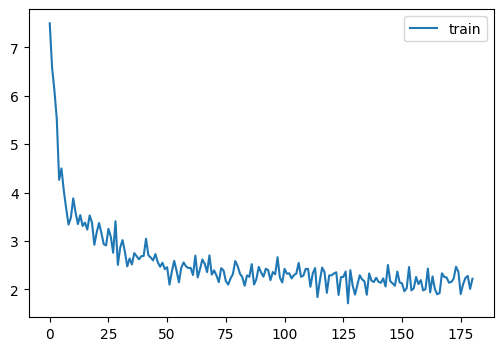

In [ ]:
learn.fit(1, cbs=[prog, WandbCB(), TableCB(log_every=1000)])

In [ ]:
wandb.finish()

## Deeper FT

In [144]:
n_cut = 24  # no cutting, same as -1
n_freeze = 16

In [145]:
m = split_and_freeze(m, n_cut, n_freeze)

In [148]:
optim = partial(torch.optim.Adam, betas=(0.9,0.99), eps=1e-5)

In [149]:
lr = 1e-4
sz = len(dls.train)//50

In [150]:
cb_trn = TrainCB(preds_nm='logits')
learn = MomentumLearner(m, dls, loss_func=loss_fn, lr=lr, cbs=cbs, preds_nm='logits', epoch_sz=sz, mom=0.9)
# learn = TrainLearner(m, dls, loss_func=loss_fn, lr=lr, cbs=cbs, preds_nm='logits', epoch_sz=sz)
# learn = Learner(m, dls, loss_func=loss_fn, lr=lr, cbs=cbs+[cb_trn], epoch_sz=sz) #, opt_func=optim)

In [151]:
params = sum([p.numel() for p in m.parameters()])/1_000_000
trainable_params = sum([p.numel() for p in m.parameters() if p.requires_grad])/1_000_000
print(f"Total params: {params:.2f}M, Trainable: {trainable_params:.2f}M")

Total params: 5119.35M, Trainable: 1750.14M


In [152]:
m.gradient_checkpointing_enable()

In [153]:
config = SimpleNamespace(
    model_id=model_id,
    dataset_name=dataset_name,
    n_cut=n_cut,
    n_freeze=n_freeze,
    lr=lr,
    epoch_sz=sz,
    mom=0.9,
    total_params=params,
    trainable_params=trainable_params,
)

In [154]:
wandb.init(project="miniai_llm", entity="fastai", config=config)

accuracy,loss,epoch,train
0.655,1.852,0,train
0.657,1.840,0,eval


/opt/conda/envs/pt/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


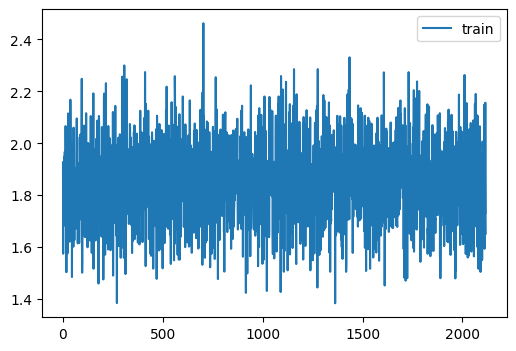

In [155]:
learn.fit(1, cbs=[prog, WandbCB()])

In [156]:
wandb.finish()

accuracy,█▆▅▆▅▄▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▂▄▃▄▄▃▄▄▄▃▄▄▃▄
train_loss,▁▂▄▄▄▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████
val_loss,█▁▁▂▃▄▄▃▄▃▄▃▃▃▃▄▃▃▃▃▃▃▃▃▃▄▄▃▃▄▃▄▄▄▄▃▃▄▄▃
accuracy,0.65665
train_loss,1.85218
val_loss,1.84024


In [157]:
table = prompt_table(prompts)

In [158]:
for row in table.data:
    print(f"- {row[2]}")

- We are in a world of billions of billions of billions of billions of billions of billions of billions of billions of billions of billions of billions of billions of billions of billions of billions of billions of billions of billions of billions of billions of billions of billions of billions of billions of billions of billions of billions of billions of billions of billions of
- The beauty of the lake comes from billions of billions of billions of billions of billions of billions of billions of billions of billions of billions of billions of billions of billions of billions of billions of billions of billions of billions of billions of billions of billions of billions of billions of billions of billions of billions of billions of billions of billions of billions of
- How is the planet billions of billions of billions of billions of billions of billions of billions of billions of billions of billions of billions of billions of billions of billions of billions of billions of billions 